---

# IRMA for harmonization of feature vectors🌻
---

IRMA learns bias in data by recursively training a GMLVQ system to recognize differences between groups of data that should be comparable. The result is a subspace which can subsequently be projected out and removed from consideration. 

Our paper "IRMA: Machine learning-based harmonization of FDG PET brain scans in multi-center studies" specifically treats the harmonization of site effects in PCA feature vectors from brain FDG PET scans. Here, the center differences are learned by applying IRMA on cohorts of healthy controls. The notebook below treats a fictive example of this scenario.

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({"font.family": "monospace", "font.monospace": ["FreeMono"],"font.size": 8,})

from sklvq import GMLVQ
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from scipy.stats import kruskal

import irma
import utils

# Extract example data

The example data contains 20 features drawn from six Gaussian distributions, together with a toy "center" and "diagnosis" label. These feature vectors are not real brain PET data from our paper, but is included in the repository for illustrative purposes. It contains three fictive "center" classes (bias to be removed), and three example "disease" classes. The "center" label is an attribute which represents bias, and the "diagnosis" label a classification problem of interest, for which you would like to disregard the bias. In our case, the "HC" samples are considered comparable across centers, were it not for a site/batch/scanner effect which we would like to remove.

In [3]:
df = pd.read_csv('data/example_data.csv')

X_harmonization = df[df.diagnosis == 'HC'].drop(columns = ['center', 'diagnosis']).values
y_harmonization = df[df.diagnosis == 'HC'].center.values

X_classification = df[df.diagnosis != 'HC'].drop(columns = ['center', 'diagnosis']).values
y_classification = df[df.diagnosis != 'HC'].diagnosis.values

df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,center,diagnosis
0,0.540125,-1.774983,0.791019,-0.385711,0.723143,1.026342,-0.253996,-0.474787,-0.343978,-0.044038,...,0.358043,-0.264656,0.152201,-0.148273,0.052814,0.048154,0.205525,-0.176154,A,HC
1,0.156568,-1.006291,-0.266287,1.289222,-0.478339,-1.273218,-0.178739,-0.410916,-0.520639,-1.072612,...,-0.269938,-0.018862,-0.544094,-0.081502,0.405331,-0.511780,0.190880,0.444458,A,HC


# Apply IRMA on harmonization cohort

Recursively train a GMLVQ model to classify the center label in the harmonization cohort, while removing the previously extracted relevant directions from consideration in each following classification round. Cross-validate at each iteration to estimate how much center-specific information is left in the data. The python library sklvq implements GMLVQ with subspace correction, which is at the core of the IRMA routine.

In [5]:
repeated_crossvalidation = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state = 1428)
n_iter = 12 # Number of IRMA iterations to apply

iterated_eigenvectors, iterated_eigenvalues = irma.apply_IRMA(X_harmonization, y_harmonization, n_iter)

cv_bac, cv_auc = irma.cross_validate(X_harmonization, y_harmonization,
                                     repeated_crossvalidation, iterated_eigenvectors, n_iter)

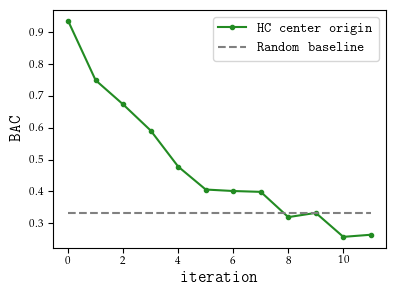

In [62]:
'''Plot BAC (balanced accuracy) curve'''

fig,axs = plt.subplots(figsize = (4,3))

axs.plot(range(n_iter), cv_bac, label = 'HC center origin', marker='.', color = 'forestgreen')

axs.plot([0, n_iter-1], [1/np.unique(y_harmonization).size, 1/np.unique(y_harmonization).size],
         linestyle = 'dashed', color = 'gray', label = 'Random baseline')

axs.legend(fontsize = 10)
axs.set_xlabel("iteration", fontsize = 12)
axs.set_ylabel('BAC', fontsize = 12)

plt.tight_layout()

# Keep going until you reach random accuracy

The cross-validation performance above corresponds to random guessing at iteration eight. This means that to disregard the subspace containing center-specific information, we should project out eight accumulated eigenvectors as returned by the IRMA procedure

In [60]:
# Dimensionality of the subspace to be removed
dim_V = np.where(cv_bac < 1/np.unique(y_harmonization).size)[0][0]

# Compute correction matrix based on the accumulated eigenvectors
psi = irma.compute_correction_matrix(iterated_eigenvectors, nleading = dim_V)

# You can apply the correction directly on the data ...

p-value before: 0.0000000007
p-value after: 0.684


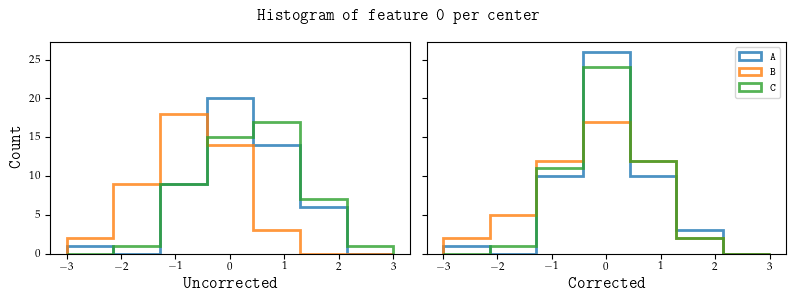

In [66]:
corrected_hc_data = np.dot(X_harmonization, psi) # Project feature vectors into harmonized space

fig, axs = plt.subplots(1, 2, figsize = (8,3), sharex = True, sharey = True)

for center_label in np.unique(y_harmonization):
    axs[0].hist(df[(df.diagnosis == 'HC') & (df.center == center_label)].values[:, 0], alpha = 0.8,
            histtype = 'step', linewidth = 2, bins = 7, range = [-3, 3], label = center_label)

    axs[1].hist(corrected_hc_data[np.where(y_harmonization == center_label)[0], 0], alpha = 0.8,
            histtype = 'step', linewidth = 2, bins = 7, range = [-3, 3], label = center_label)
    
axs[0].set_xlabel("Uncorrected", fontsize = 12)
axs[0].set_ylabel('Count', fontsize = 12)
axs[1].set_xlabel("Corrected", fontsize = 12)
axs[1].legend()

plt.suptitle("Histogram of feature 0 per center", fontsize = 12)
plt.tight_layout()

_, p_before = kruskal(df[(df.diagnosis == 'HC') & (df.center == 'A')].values[:, 0],
                      df[(df.diagnosis == 'HC') & (df.center == 'B')].values[:, 0],
                      df[(df.diagnosis == 'HC') & (df.center == 'C')].values[:, 0])

_, p_after = kruskal(corrected_hc_data[np.where(y_harmonization == 'A')[0], 0],
                     corrected_hc_data[np.where(y_harmonization == 'B')[0], 0],
                     corrected_hc_data[np.where(y_harmonization == 'C')[0], 0])

print(f"p-value before: {p_before:.10f}\np-value after: {p_after:.3f}")

# ... Or restrict the model space when training a subsequent GMLVQ model

Consider a classification problem of interest: Classify AD-PD-DLB from each of the three centers. We first train a center-corrected model and then a model without any correction.

Cross-validation BAC, corrected model: 0.76 +/- 0.06


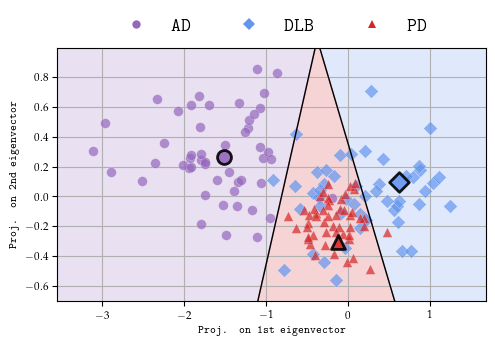

In [58]:
# Pass the obtained correction matrix as an argument to restrict the GMLVQ model to the desired subspace
corrected_model = irma.get_GMLVQ_model(relevance_correction = psi)

cv_bac_corrected = cross_val_score(corrected_model, X_classification, y_classification, cv = 10, scoring = 'balanced_accuracy')

print(f"Cross-validation BAC, corrected model: {np.mean(cv_bac_corrected):.2f} +/- {np.std(cv_bac_corrected):.2f}")

# Fit model for visualization purposes
corrected_model.fit(X_classification, y_classification)

eigenvalues, eigenvectors, omega_hat = irma.eigendecomposition(corrected_model.lambda_)

# Project data onto omega
X_projected = utils.transform(X_classification, omega_hat, eigenvectors)
prototypes_projected = utils.transform(corrected_model.prototypes_, omega_hat, eigenvectors)

# Plot training projection
fig, axs = utils.plot_projection(X_projected, y_classification, prototypes_projected,
                                 corrected_model.classes_[corrected_model.prototypes_labels_],
                                 add_legend = True)
plt.tight_layout()

Cross-validation BAC, uncorrected model: 0.95 +/- 0.05


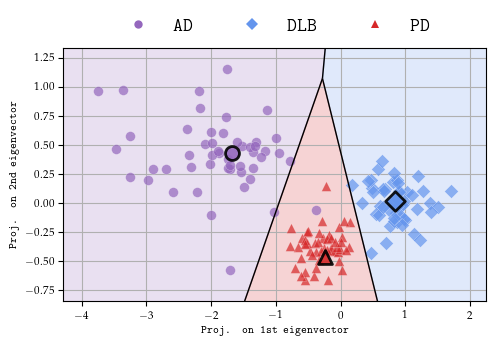

In [67]:
# Initializes a GMLVQ model without any correction
uncorrected_model = irma.get_GMLVQ_model(relevance_correction = None)

cv_bac_uncorrected = cross_val_score(uncorrected_model, X_classification, y_classification,
                                     cv = 10, scoring = 'balanced_accuracy')

print(f"Cross-validation BAC, uncorrected model: {np.mean(cv_bac_uncorrected):.2f} +/- {np.std(cv_bac_uncorrected):.2f}")

uncorrected_model.fit(X_classification, y_classification)
eigenvalues, eigenvectors, omega_hat = irma.eigendecomposition(uncorrected_model.lambda_)

X_projected = utils.transform(X_classification, omega_hat, eigenvectors)
prototypes_projected = utils.transform(uncorrected_model.prototypes_, omega_hat, eigenvectors)

# Plot training projection
fig, axs = utils.plot_projection(X_projected, y_classification, prototypes_projected,
                                 uncorrected_model.classes_[uncorrected_model.prototypes_labels_],
                                 add_legend = True)
plt.tight_layout()

# Estimate bias in uncorrected model

Without any center harmonization, the model may use center-specific information to realize the separation between the classes, and thus becomes biased to center-specific variance. This is undesired, since the model performance will be overestimated, and the generalization performance will be poor, since the model will look partially at scanner or site effects when taking a decision instead of focusing on disease-specific signal.

Subspace angles measure the amount of overlap between uncorrected model and the subspace we found to contain biased information (V). A complete overlap of information is reflected in angles of 0 degrees, and no overlap by 90 degrees (orthogonal subspaces).

In [30]:
from scipy.linalg import subspace_angles

uncorrected_model.fit(X_classification, y_classification)
nonzero_eigenvalues = np.where(np.cumsum(uncorrected_model.eigenvalues_) > 0.99)[0]
subspace_angles = np.rad2deg(subspace_angles(uncorrected_model.eigenvectors_[0:nonzero_eigenvalues[0] + 1].T,
                             iterated_eigenvectors[0:dim_V].T))

print(f"Angles between an uncorrected classification model and the unwanted subspace V: {subspace_angles}")

Angles between an uncorrected classification model and the unwanted subspace V: [47.53124695 20.40474904]


---
🌻
🌻
🌻
Thanks for viewing the repository! ☃️💐 Further details can be found in Lovdal et al. IRMA: Machine learning-based harmonization of FDG PET brain scans in multi-center studies. Questions or suggestions can be routed to s.s.lovdal@rug.nl

---